<a href="https://colab.research.google.com/github/aekanun2020/2022-PSU-Data-Science-for-Tourism-Course2/blob/main/2_demo_stackbar_and_informationGain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder \
   .appName("Neural Network Model") \
   .config("spark.executor.memory", "3gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [7]:
raw_dictionary_in_list = [\
                           {'Outlook':'sunny','Temperature':'hot','Humidity':'high','Windy':'FALSE','Game':'no'}\
                          ,{'Outlook':'sunny','Temperature':'hot','Humidity':'high','Windy':'TRUE','Game':'no'}\
                          ,{'Outlook':'overcast','Temperature':'hot','Humidity':'high','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'rainy','Temperature':'mild','Humidity':'high','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'rainy','Temperature':'cool','Humidity':'normal','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'rainy','Temperature':'cool','Humidity':'normal','Windy':'TRUE','Game':'no'}\
                          ,{'Outlook':'overcast','Temperature':'cool','Humidity':'normal','Windy':'TRUE','Game':'yes'}\
                          ,{'Outlook':'sunny','Temperature':'mild','Humidity':'high','Windy':'FALSE','Game':'no'}\
                          ,{'Outlook':'sunny','Temperature':'mild','Humidity':'normal','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'rainy','Temperature':'mild','Humidity':'normal','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'sunny','Temperature':'mild','Humidity':'normal','Windy':'TRUE','Game':'yes'}\
                          ,{'Outlook':'overcast','Temperature':'mild','Humidity':'high','Windy':'TRUE','Game':'yes'}\
                          ,{'Outlook':'overcast','Temperature':'hot','Humidity':'normal','Windy':'FALSE','Game':'yes'}\
                          ,{'Outlook':'rainy','Temperature':'mild','Humidity':'high','Windy':'TRUE','Game':'no'}\
                          ]

In [8]:
from pyspark.sql import functions as sparkf

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

In [10]:
raw_df = spark.createDataFrame(raw_dictionary_in_list)

/content/spark-2.4.1-bin-hadoop2.7/python/pyspark/sql/session.py:346: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


In [11]:
raw_df.show()

+----+--------+--------+-----------+-----+
|Game|Humidity| Outlook|Temperature|Windy|
+----+--------+--------+-----------+-----+
|  no|    high|   sunny|        hot|FALSE|
|  no|    high|   sunny|        hot| TRUE|
| yes|    high|overcast|        hot|FALSE|
| yes|    high|   rainy|       mild|FALSE|
| yes|  normal|   rainy|       cool|FALSE|
|  no|  normal|   rainy|       cool| TRUE|
| yes|  normal|overcast|       cool| TRUE|
|  no|    high|   sunny|       mild|FALSE|
| yes|  normal|   sunny|       mild|FALSE|
| yes|  normal|   rainy|       mild|FALSE|
| yes|  normal|   sunny|       mild| TRUE|
| yes|    high|overcast|       mild| TRUE|
| yes|  normal|overcast|        hot|FALSE|
|  no|    high|   rainy|       mild| TRUE|
+----+--------+--------+-----------+-----+



In [12]:
raw_df.printSchema()

root
 |-- Game: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Outlook: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Windy: string (nullable = true)



In [13]:
raw_df.groupBy('Outlook','Game').agg(sparkf.count('Game'))\
.orderBy('Outlook').show()

+--------+----+-----------+
| Outlook|Game|count(Game)|
+--------+----+-----------+
|overcast| yes|          4|
|   rainy|  no|          2|
|   rainy| yes|          3|
|   sunny| yes|          2|
|   sunny|  no|          3|
+--------+----+-----------+



In [14]:
target_var = 'Game'

for c in raw_df.columns:
  raw_df.groupBy(c,target_var).agg(sparkf.count(target_var))\
  .orderBy(c).show()

+----+----+-----------+
|Game|Game|count(Game)|
+----+----+-----------+
|  no|  no|          5|
| yes| yes|          9|
+----+----+-----------+

+--------+----+-----------+
|Humidity|Game|count(Game)|
+--------+----+-----------+
|    high|  no|          4|
|    high| yes|          3|
|  normal|  no|          1|
|  normal| yes|          6|
+--------+----+-----------+

+--------+----+-----------+
| Outlook|Game|count(Game)|
+--------+----+-----------+
|overcast| yes|          4|
|   rainy| yes|          3|
|   rainy|  no|          2|
|   sunny| yes|          2|
|   sunny|  no|          3|
+--------+----+-----------+

+-----------+----+-----------+
|Temperature|Game|count(Game)|
+-----------+----+-----------+
|       cool|  no|          1|
|       cool| yes|          2|
|        hot|  no|          2|
|        hot| yes|          2|
|       mild|  no|          2|
|       mild| yes|          5|
+-----------+----+-----------+

+-----+----+-----------+
|Windy|Game|count(Game)|
+-----+----+----

In [30]:
def draw_histogram_forCategoricalVar(x_var,groupby_var,df):
  # Prepare data
  #x_var = 'manufacturer'
  #groupby_var = 'class'
  df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
  vals = [df[x_var].values.tolist() for i, df in df_agg]

  # Draw
  plt.figure(figsize=(16,9), dpi= 80)
  colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
  n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

  # Decoration
  plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
  plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
  plt.xlabel(x_var)
  plt.ylabel("Frequency")
  plt.ylim(0, 15)
  plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
  plt.show()

In [27]:
raw_pd = raw_df.toPandas()

/usr/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('127.0.0.1', 54548), raddr=('127.0.0.1', 37937)>
  self._sock = None


In [28]:
raw_pd

,Game,Humidity,Outlook,Temperature,Windy
0,no,high,sunny,hot,FALSE
1,no,high,sunny,hot,TRUE
2,yes,high,overcast,hot,FALSE
3,yes,high,rainy,mild,FALSE
4,yes,normal,rainy,cool,FALSE
5,no,normal,rainy,cool,TRUE
6,yes,normal,overcast,cool,TRUE
7,no,high,sunny,mild,FALSE
8,yes,normal,sunny,mild,FALSE
9,yes,normal,rainy,mild,FALSE


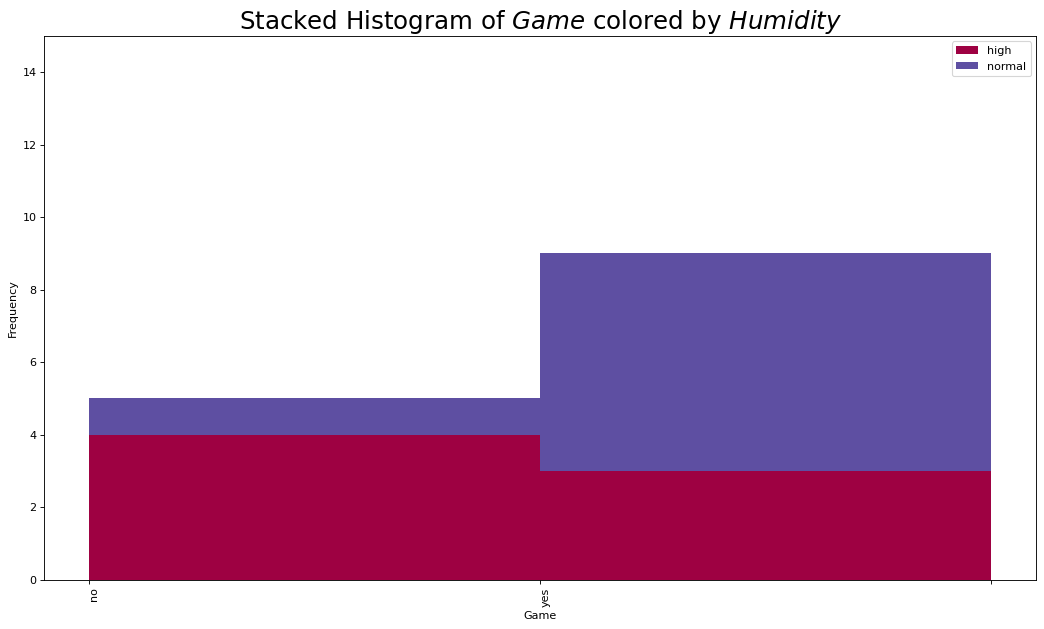

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


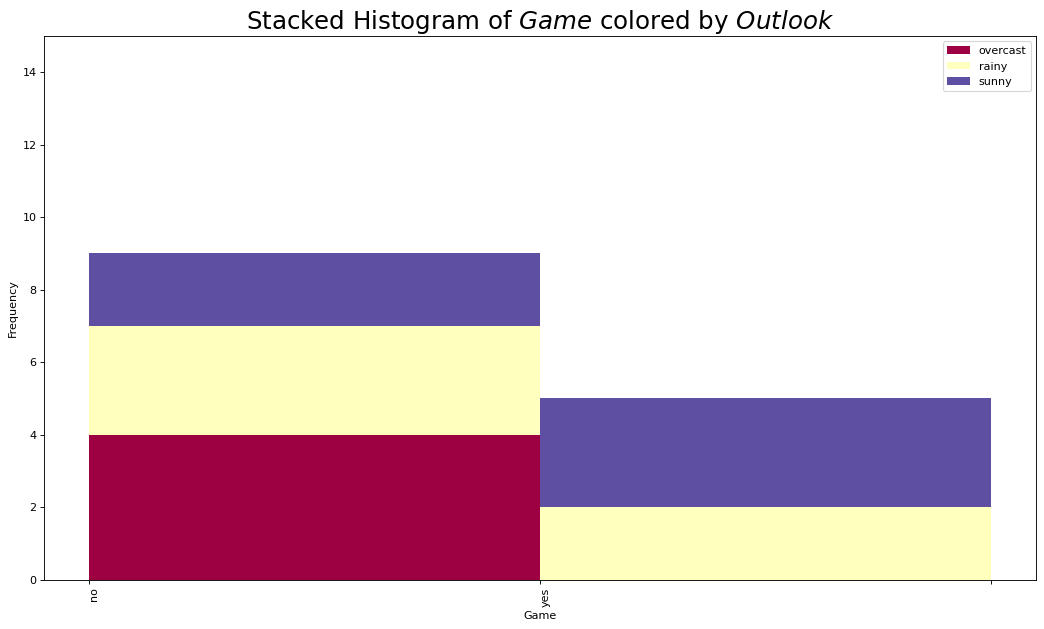

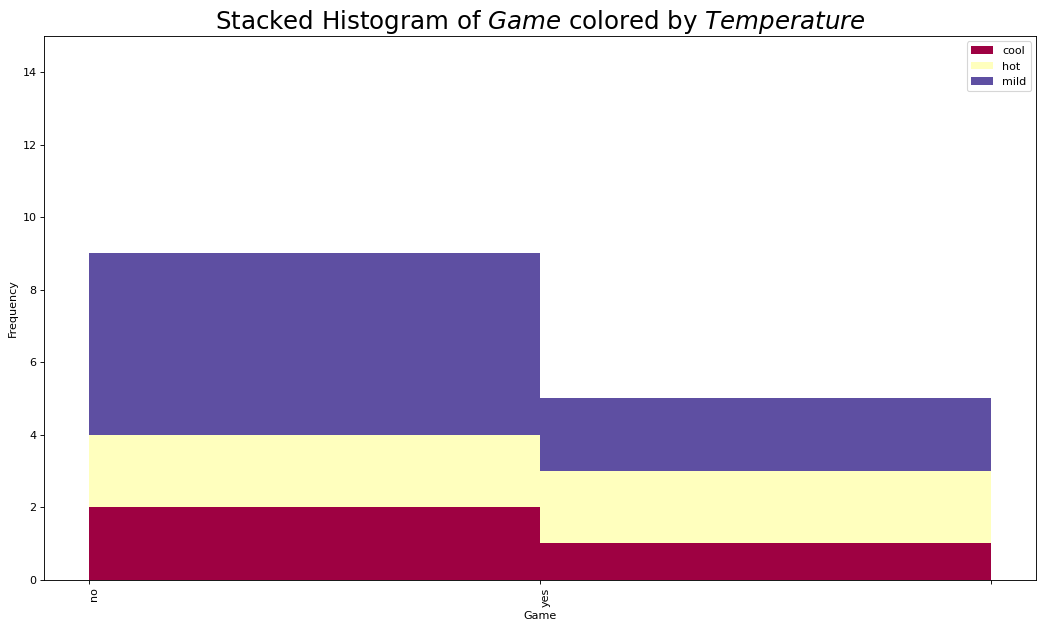

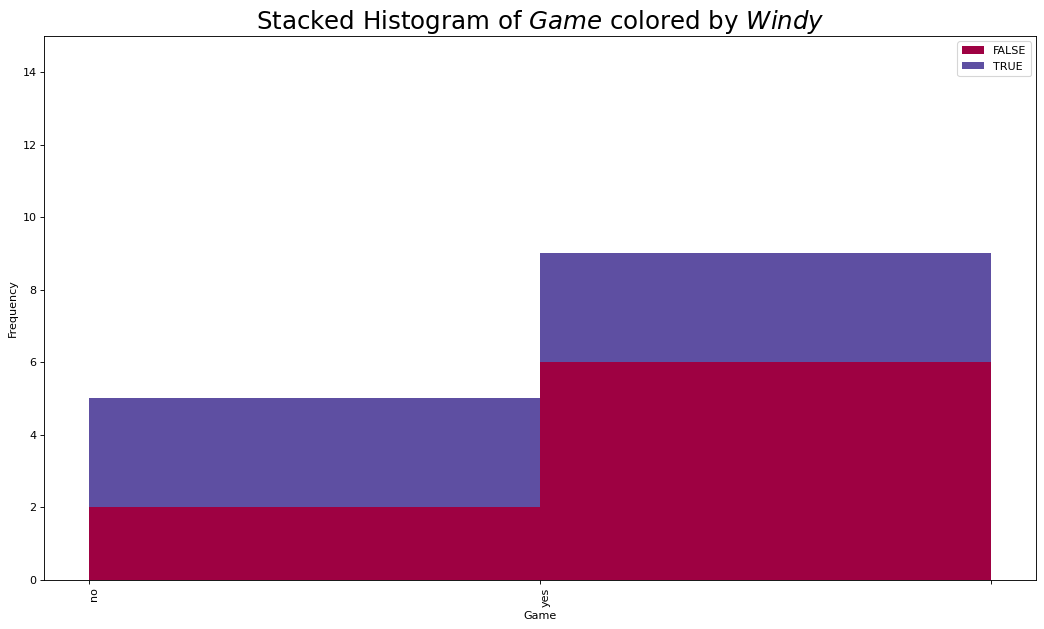

In [31]:
for c in [x for x in raw_df.columns if x != 'Game']:
  draw_histogram_forCategoricalVar(target_var,c,raw_pd)